In [15]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from numpy.linalg import svd as SVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import precision_score, accuracy_score, recall_score 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle

plt.style.use('ggplot')
%matplotlib inline 



In [7]:
reviews = pd.read_csv('../../data/yelp.csv', index_col=0)



In [8]:
#this column is empty 
reviews.drop('business_neighborhoods', axis=1, inplace=True)

In [9]:
#i want to only deal with restaurants 
reviews = reviews[reviews['business_categories'].str.contains('Restaurant') == True]

In [10]:
# reviews.info()

In [11]:
#there are six entries with no text review, going to drop 
no_rev = reviews[pd.isna(reviews['text']) == True].index 
reviews.drop(labels=no_rev, axis=0, inplace=True)

In [12]:
reviews = reviews.reset_index().drop('index', axis=1)

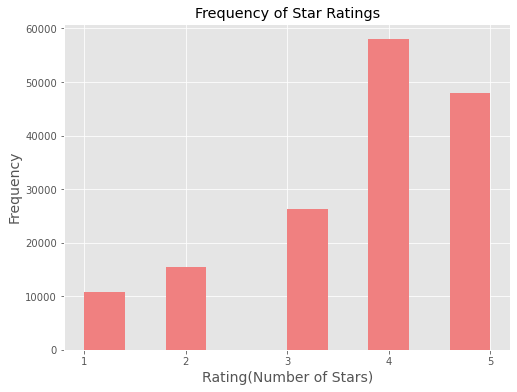

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(reviews['stars'], color = 'lightcoral')
ax.set_xticks(np.arange(1,6))
ax.set_xlabel('Rating(Number of Stars)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Frequency of Star Ratings')
plt.savefig('../../img/ratings-hist.png')


In [78]:
#why don't i model based on the vectorized feature matrix of the text component of reviews
#going to begin with a simple baseline (the mean), then move onto a logistic regressor 
#first going to split the data into training, testing, and holdout 
# X = vectorized.toarray()
# Y = reviews['stars'].values
# x, X_holdout, y, y_holdout = train_test_split(X, Y )

In [7]:
from text_pipeline import TextPrep

In [18]:
# pipeline = TextPrep(reviews)
# X = pipeline.vectorize('text')
# my imported class keeps throwing an error so going to just manually import function for now 

In [8]:
def vectorize(df ,column, method='tfidf'):
        #takes in name of column to be cleaned, and method to vectorize
        lem = WordNetLemmatizer()
        #lemmatizing as opposed to stemming 
        s_words = stopwords.words('english')
        texts = []
        for doc in df[column].values:
            cleaned = [lem.lemmatize(word).lower() for word in doc.split(' ') \
                       if word not in s_words and word.isalpha() == True]
            #making sure that every word onl
            texts.append(' '.join(cleaned))
  
        if method == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
            vectorized = vectorizer.fit_transform(texts).toarray()
            return vectorized
            #creating a feature names attribute(bag of words)
        elif method == 'count':
            vectorizer = CountVectorizer(stop_words='english', max_features=5000)
            vectorized = vectorizer.fit_transform(self.documents).toarray()
            return vectorized

In [9]:
x = vectorize(reviews, 'text')
y = reviews['stars'].values

In [10]:
def scores(y_true, y_predict):
    precision = precision_score(y_true, y_predict,average='macro')
    accuracy = accuracy_score(y_true, y_predict)
    recall = recall_score(y_true, y_predict, average='macro')
    print(f'Precision : {precision} \n'  
          f'Accuracy : {accuracy} \n'
         f'Recall: {recall}')
    return [precision, accuracy, recall]

In [11]:
#baseline will be the mode, 4
y_mode = np.array([4] * len(y))
baseline_ = scores(y, y_mode)

Precision : 0.07320229258193203 
Accuracy : 0.36601146290966013 
Recall: 0.2


/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
#now lets make proper splits 
X_train, X_holdout, y_train, y_holdout = train_test_split(x, y)
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train)

In [15]:
#going to start with simple logistic regression and check the error 
log_model = LogisticRegression().fit(X_subtrain, y_subtrain)
yhat_log = log_model.predict(X_subtest)


/Users/user/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
scores(y_subtest, yhat_log)
#lets pickle the model 
pickle.dump(log_model, open('log_model.pkl', 'wb'))


Precision : 0.5080392677608373 
Accuracy : 0.5206867530718734 
Recall: 0.4665495774252085


In [18]:
final_yhat_log = log_model.predict(X_holdout)
log_scores = scores(y_holdout,final_yhat_log)
#results for logistic regression 

Precision : 0.5107873954553696 
Accuracy : 0.5298187143362116 
Recall: 0.4695066393621798


In [57]:
#randomforestnext - out of box first then will gridsearch.
rm = RandomForestClassifier(class_weight='balanced').fit(X_subtrain, y_subtrain)
rm_hat = rm.predict(X_subtest)
scores(y_subtest, rm_hat)

Precision : 0.46370944265991304 
Accuracy : 0.46712674633900014 
Recall: 0.3622393236900735


[0.46370944265991304, 0.46712674633900014, 0.3622393236900735]

In [33]:
#i have alreaedy done a grid search, not shown here due to computational cost
rm_final = RandomForestClassifier(class_weight='balanced_subsample', max_samples=.5).fit(X_subtrain, y_subtrain)

In [34]:
rm_final_hat = rm_final.predict(X_holdout)
rm_scores = scores(y_holdout, rm_final_hat)

Precision : 0.46872207598811944 
Accuracy : 0.468944099378882 
Recall: 0.35804206652494236


In [36]:
#lets move on to gradient boosting - after this going to undersample to figure out class imbalance 
gb = GradientBoostingClassifier().fit(X_subtrain, y_subtrain)

KeyboardInterrupt: 